<a href="https://colab.research.google.com/github/krishbharucha/XAI/blob/main/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap surprise -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


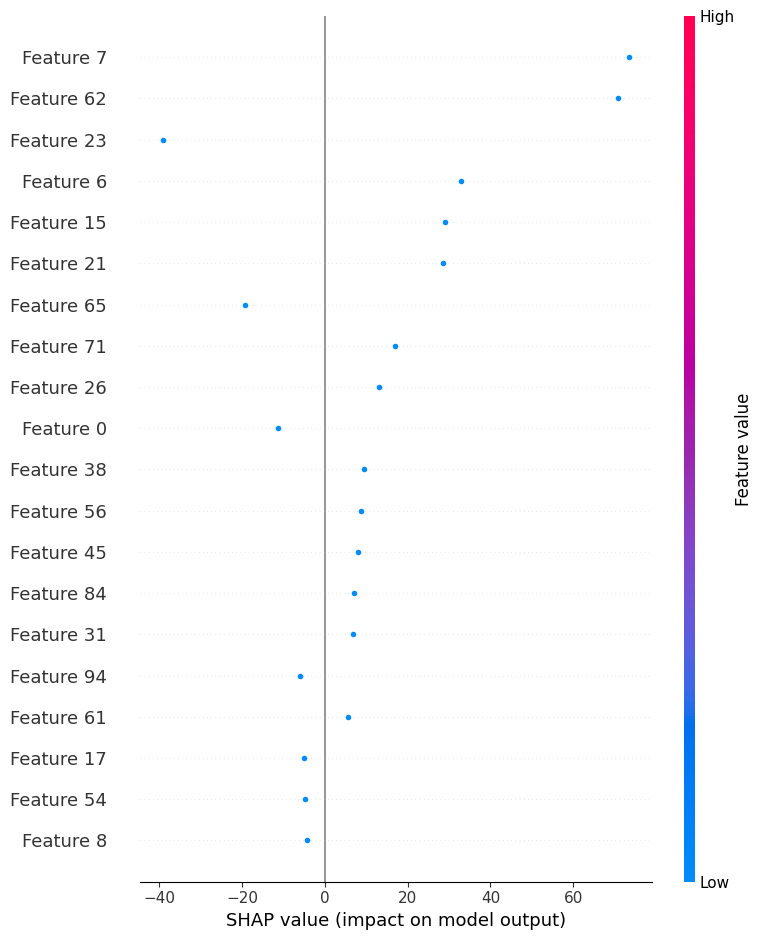

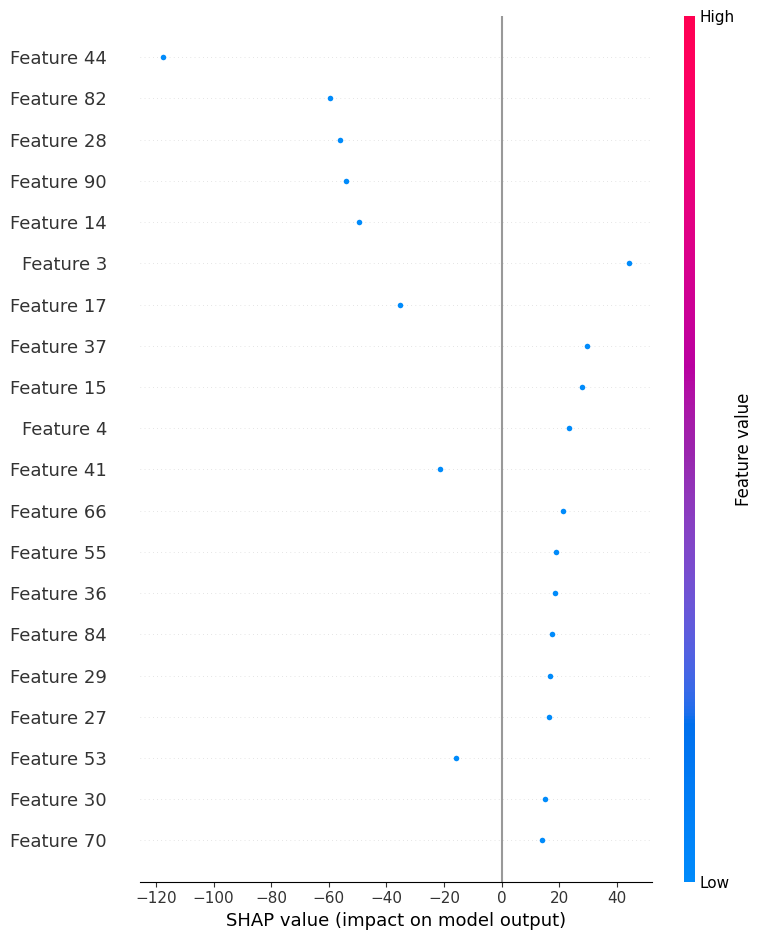

In [ ]:
import surprise
import shap
import numpy as np
from sklearn.tree import DecisionTreeRegressor


# Load the ML-100k dataset
data = surprise.Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
algo = surprise.SVD()
algo.fit(trainset)

user_factors = algo.pu
item_factors = algo.qi

# Train Explainable Models for User and Item Features

user_model = DecisionTreeRegressor()
user_model.fit(user_factors, trainset.all_users())


item_model = DecisionTreeRegressor()
item_model.fit(item_factors, trainset.all_items())

# SHAP for Explainable AI
# Initialize the SHAP explainer with the trained models
explainer_user = shap.TreeExplainer(user_model)
explainer_item = shap.TreeExplainer(item_model)

# Sample a user and an item for explanation
user_index = np.random.choice(len(trainset.all_users()))
item_index = np.random.choice(len(trainset.all_items()))


shap_values_user = explainer_user.shap_values(user_factors[user_index].reshape(1, -1))
shap_values_item = explainer_item.shap_values(item_factors[item_index].reshape(1, -1))

#  Visual Representation

shap.summary_plot(shap_values_user, user_factors[user_index].reshape(1, -1))
shap.summary_plot(shap_values_item, item_factors[item_index].reshape(1, -1))


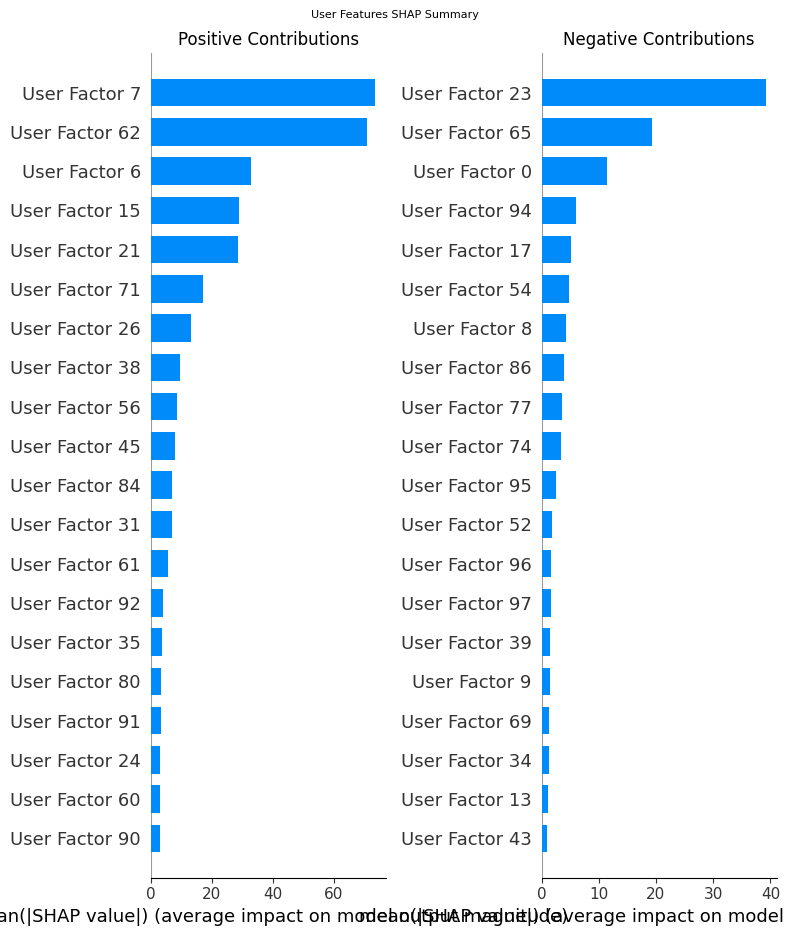

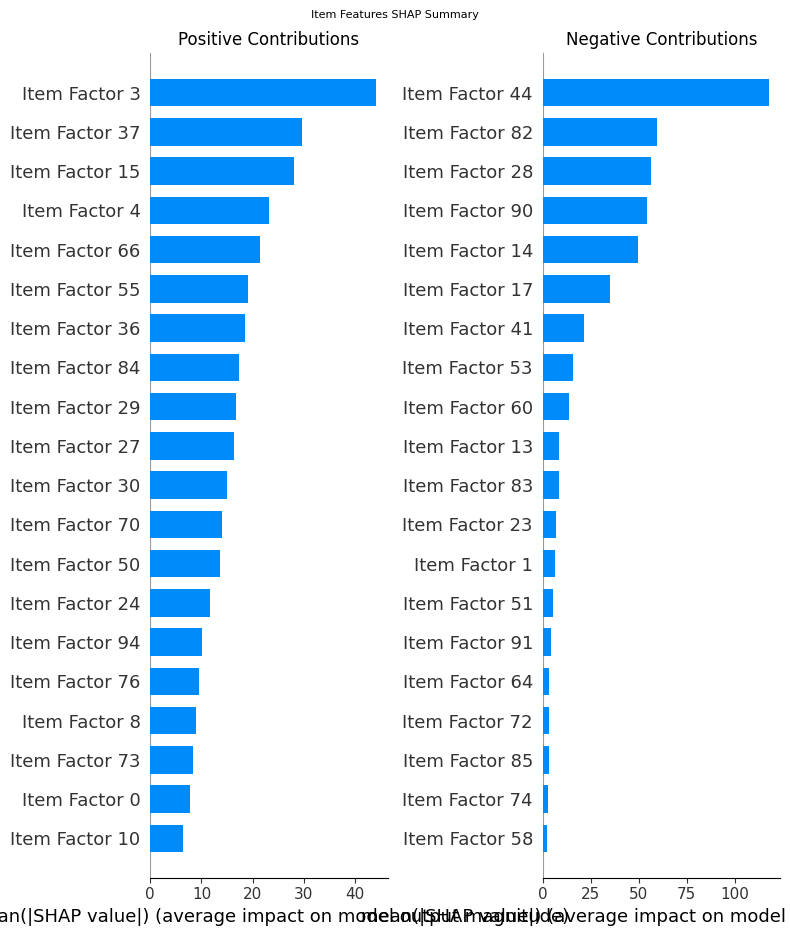

In [ ]:
import matplotlib.pyplot as plt

def plot_shap_summary(shap_values, feature_names, title):
    # Separate positive and negative SHAP values
    positive_shap = shap_values.clip(min=0)
    negative_shap = shap_values.clip(max=0)

    # Plot positive and negative SHAP values separately
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    shap.summary_plot(positive_shap, feature_names=feature_names, plot_type='bar', show=False)
    plt.title('Positive Contributions')

    plt.subplot(1, 2, 2)
    shap.summary_plot(negative_shap, feature_names=feature_names, plot_type='bar', show=False)
    plt.title('Negative Contributions')

    plt.suptitle(title, fontsize=8)
    plt.tight_layout()
    plt.show()

# Plot SHAP summary plots for user and item features
plot_shap_summary(shap_values_user, [f'User Factor {i}' for i in range(user_factors.shape[1])], 'User Features SHAP Summary')
plot_shap_summary(shap_values_item, [f'Item Factor {i}' for i in range(item_factors.shape[1])], 'Item Features SHAP Summary')


  0%|          | 0/1 [00:00<?, ?it/s]

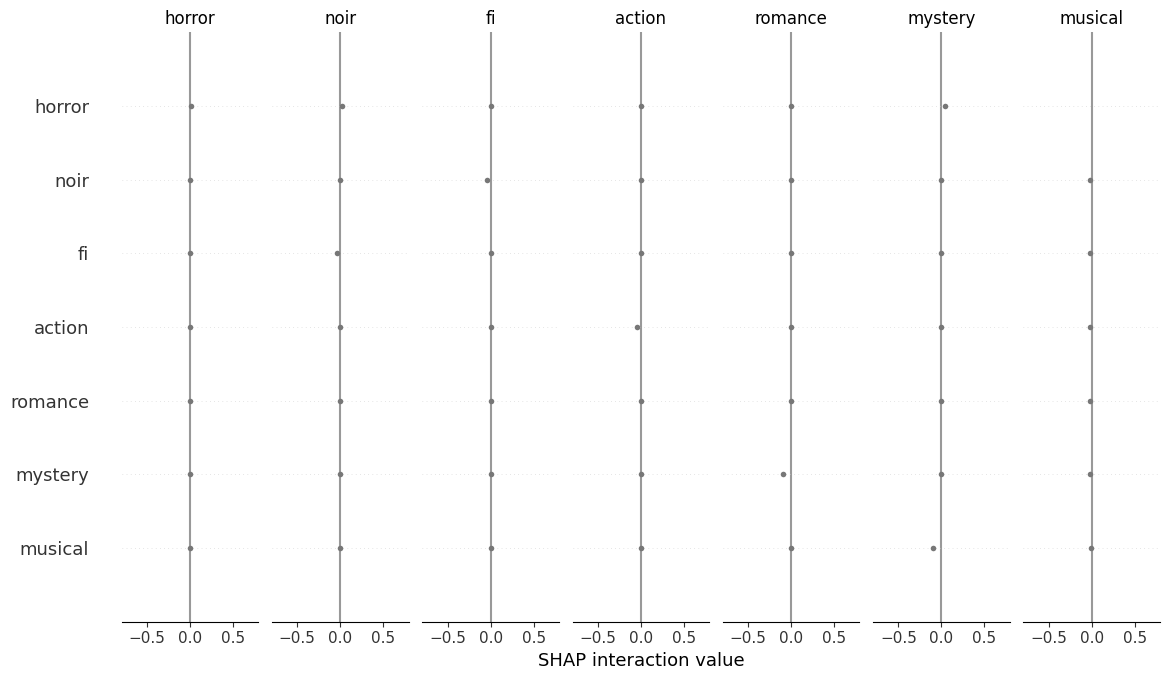

In [ ]:
import pandas as pd
from surprise import Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import shap

data = Dataset.load_builtin('ml-100k')

df = pd.DataFrame(data.raw_ratings, columns=["userId", "movieId", "rating", "timestamp"])


movie_info = pd.read_csv("http://files.grouplens.org/datasets/movielens/ml-100k/u.item", sep='|', header=None, encoding='latin-1', index_col=0)
movie_info.columns = ['title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


df['movieId'] = df['movieId'].astype(int)


df = df.merge(movie_info[['title', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']], left_on='movieId', right_index=True)


item_features = df[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]
item_features = item_features.astype(float)

tfidf_vectorizer = TfidfVectorizer()
item_features_tfidf = tfidf_vectorizer.fit_transform(item_features)

# Content-Based Filtering function
def content_based_filtering(user_profile, item_features_tfidf=item_features_tfidf):
    # Compute cosine similarity between user profile and item features
    similarity_scores = cosine_similarity(user_profile, item_features_tfidf)
    return similarity_scores


user_profile = item_features_tfidf[np.random.randint(item_features_tfidf.shape[0])].reshape(1, -1)

# Compute SHAP values for the content-based filtering model
explainer = shap.KernelExplainer(content_based_filtering, shap.sample(item_features_tfidf, nsamples=100), link="identity")
shap_values = explainer.shap_values(user_profile, nsamples=100, l1_reg='aic')


shap.summary_plot(shap_values, item_features_tfidf, feature_names=tfidf_vectorizer.get_feature_names_out(), plot_type='bar', show=False)


<ipython-input-12-2c7d62242434>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


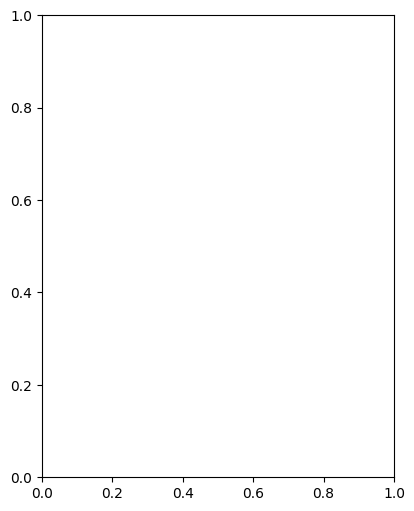

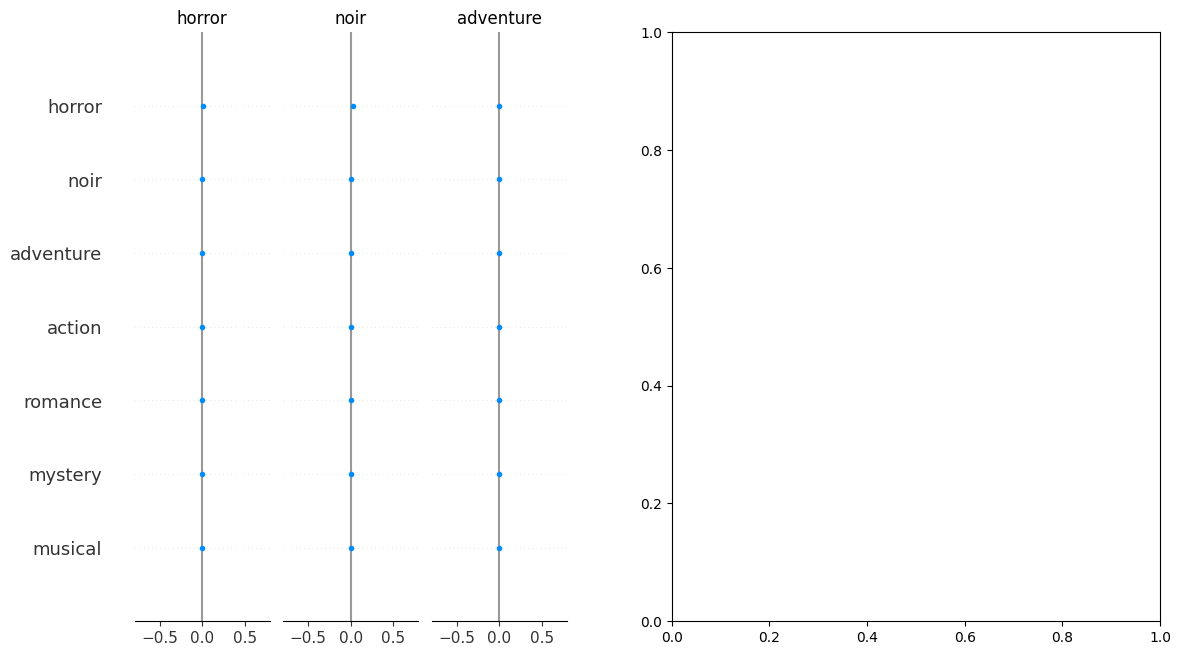

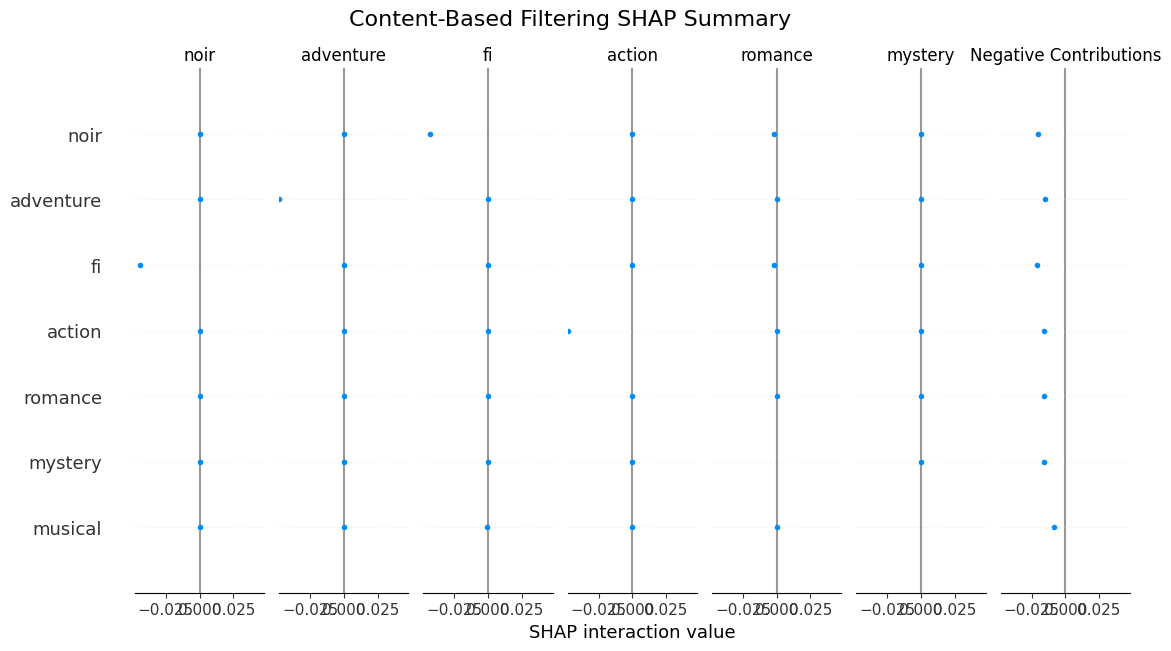

In [ ]:
import matplotlib.pyplot as plt


def plot_shap_summary(shap_values, feature_names, title):
    # Separate positive and negative SHAP values
    positive_shap = shap_values.clip(min=0)
    negative_shap = shap_values.clip(max=0)

    # Plot positive and negative SHAP values separately
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    shap.summary_plot(positive_shap, feature_names=feature_names, plot_type='bar', show=False)
    plt.title('Positive Contributions')

    plt.subplot(1, 2, 2)
    shap.summary_plot(negative_shap, feature_names=feature_names, plot_type='bar', show=False)
    plt.title('Negative Contributions')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


plot_shap_summary(shap_values, tfidf_vectorizer.get_feature_names_out(), 'Content-Based Filtering SHAP Summary')


COLLABORATIVE FILTERING FULL WORKING


In [ ]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from path import Path
import tqdm

In [ ]:
pip install umap

In [ ]:
pip install path.py


In [ ]:
data = surprise.Dataset.load_builtin('ml-100k')


In [ ]:
import pandas as pd
from surprise import Dataset



df = pd.DataFrame(data.raw_ratings, columns=['userId', 'itemId', 'rating', 'timestamp'])


rating = df[['userId', 'itemId', 'rating']]


rating_test_1 = rating.copy()

rating.head()



,userId,itemId,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [ ]:
n_users = rating['userId'].nunique()
n_movies = rating['itemId'].nunique()
n_users, n_movies

(943, 1682)

In [ ]:
class MLensDataset(Dataset):
    def __init__(self, df):
        self.rating = df

    def __len__(self):
        return len(self.rating)

    def __getitem__(self, idx):
        user = torch.tensor(self.rating.iloc[idx]['userId'], dtype=torch.long)
        movie = torch.tensor(self.rating.iloc[idx]['itemId'], dtype=torch.long)
        rating = torch.tensor(self.rating.iloc[idx]['rating'], dtype=torch.float)

        # Move tensors to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        user, movie, rating = user.to(device), movie.to(device), rating.to(device)

        return user, movie, rating

dls = MLensDataset(rating)

In [ ]:
def sigmoid_range(x, low, high):
    return low + (high - low) * torch.sigmoid(x)

In [ ]:
class DotProduct(nn.Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        super(DotProduct, self).__init__()
        self.user_embedding = nn.Embedding(n_users+1, n_factors)
        self.user_bias = nn.Embedding(n_users+1, 1)
        self.movie_embedding = nn.Embedding(n_movies+1, n_factors)
        self.movie_bias = nn.Embedding(n_movies+1, 1)
        self.y_range = y_range

    def forward(self, userid, movieid):
        users = self.user_embedding(userid)
        movies = self.movie_embedding(movieid)
        res = (users*movies).sum()
        res += self.user_bias(userid).squeeze() + self.movie_bias(movieid).squeeze()

        return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProduct(n_users, n_movies, 50)
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
loss_func = nn.MSELoss()

# use gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DotProduct(
  (user_embedding): Embedding(944, 50)
  (user_bias): Embedding(944, 1)
  (movie_embedding): Embedding(1683, 50)
  (movie_bias): Embedding(1683, 1)
)

Collaborative BASED FILTERING

  0%|          | 0/1682 [00:00<?, ?it/s]

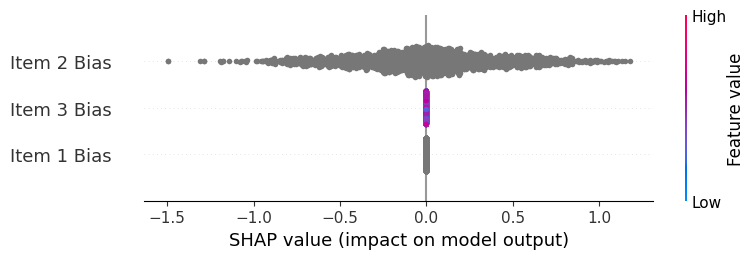

In [ ]:
import shap
from surprise import Dataset, Reader
from surprise import SVD
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
import pandas as pd
from functools import partial  # Import functools for partial function

# **Define the custom function here**
def prepare_data_for_shap(df, predicted_ratings):

  data = []
  for i, row in df.iterrows():
    user_id = row['user_id']
    item_id = row['item_id']
    predicted_rating = predicted_ratings[i]
    data.append((user_id, item_id, predicted_rating))
  return data

# Load ML-100k dataset using Surprise
reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_builtin('ml-100k')


trainset = data.build_full_trainset()
model = SVD()
model.fit(trainset)

random_user_id = str(np.random.randint(1, trainset.n_users))


item_ids = list(range(1, trainset.n_items + 1))

# Create a function to predict ratings for a given user and item
def predict_ratings(user_id, item_id):
    prediction = model.predict(user_id, item_id)
    return prediction.est

predict_ratings_partial = partial(predict_ratings, random_user_id)  # Fix user_id

# Generate user-item pairs for the random user
user_item_pairs = [(random_user_id, str(item_id)) for item_id in item_ids]

user_item_pairs_df = pd.DataFrame(user_item_pairs, columns=['user_id', 'item_id'])


predicted_ratings = np.array([predict_ratings(random_user_id, str(item_id)) for item_id in item_ids])

scaler = MaxAbsScaler()
predicted_ratings_scaled = scaler.fit_transform(predicted_ratings.reshape(-1, 1)).flatten()

data_for_shap = prepare_data_for_shap(user_item_pairs_df, predicted_ratings_scaled)

def predict_ratings_for_shap(data_for_shap):
  predictions = []
  for user_id, item_id, _ in data_for_shap:  # Ignore the predicted rating in the loop
    prediction = model.predict(user_id, item_id)
    predictions.append(prediction.est)
  return np.array(predictions)

user_item_pairs_df['predicted_rating'] = predict_ratings_for_shap(data_for_shap)

# Use SHAP explainer with the prepared data
explainer = shap.KernelExplainer(predict_ratings_for_shap, np.array(data_for_shap), link="identity")
shap_values = explainer.shap_values(np.array(data_for_shap))


shap.summary_plot(shap_values, user_item_pairs_df,
                  feature_names=[f'Item {i} Bias' for i in range(1, trainset.n_items + 1)], plot_type='dot', show=False)
